# CSV to SQL

In [6]:
import pandas as pd
import mysql.connector
import os

# List of CSV files and their corresponding table names
csv_files = [
    ('HR Data.csv', 'HR_data'),
    # Added payments.csv for specific handling
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='',
    user='',
    password='',
    database=''
)
cursor = conn.cursor()

# Folder containing the CSV files
folder_path = ""

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '').replace('-', '').replace('.', '_') for col in df.columns]
    
    # Sanitize table name
    table_name = table_name.replace(' ', '').replace('-', '').replace('.', '_')
    
    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'{col} {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS {table_name} ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO {table_name} ({', '.join(df.columns)}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()

Processing HR Data.csv
NaN values before replacement:
Age                         0
Attrition                   0
BusinessTravel              0
DailyRate                   0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EmployeeCount               0
EmployeeNumber              0
EnvironmentSatisfaction     0
Gender                      0
HourlyRate                  0
JobInvolvement              0
JobLevel                    0
JobRole                     0
JobSatisfaction             0
MaritalStatus               0
MonthlyIncome               0
MonthlyRate                 0
NumCompaniesWorked          0
Over18                      0
OverTime                    0
PercentSalaryHike           0
PerformanceRating           0
RelationshipSatisfaction    0
StandardHours               0
StockOptionLevel            0
TotalWorkingYears           0
TrainingTimesLastYear       0
WorkLifeBalance             0
YearsAtCompany  

# First Look

In [7]:
df.shape

(1470, 35)

In [8]:
df.isnull().sum()

Age                         0
Attrition                   0
BusinessTravel              0
DailyRate                   0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EmployeeCount               0
EmployeeNumber              0
EnvironmentSatisfaction     0
Gender                      0
HourlyRate                  0
JobInvolvement              0
JobLevel                    0
JobRole                     0
JobSatisfaction             0
MaritalStatus               0
MonthlyIncome               0
MonthlyRate                 0
NumCompaniesWorked          0
Over18                      0
OverTime                    0
PercentSalaryHike           0
PerformanceRating           0
RelationshipSatisfaction    0
StandardHours               0
StockOptionLevel            0
TotalWorkingYears           0
TrainingTimesLastYear       0
WorkLifeBalance             0
YearsAtCompany              0
YearsInCurrentRole          0
YearsSince

In [10]:
df.duplicated().sum()

0

In [13]:
for column in df.columns:
    if df[column].dtype==object:
        print ("{} : {} ".format(column,df[column].unique()))

Attrition : ['Yes' 'No'] 
BusinessTravel : ['Travel_Rarely' 'Travel_Frequently' 'Non-Travel'] 
Department : ['Sales' 'Research & Development' 'Human Resources'] 
EducationField : ['Life Sciences' 'Other' 'Medical' 'Marketing' 'Technical Degree'
 'Human Resources'] 
Gender : ['Female' 'Male'] 
JobRole : ['Sales Executive' 'Research Scientist' 'Laboratory Technician'
 'Manufacturing Director' 'Healthcare Representative' 'Manager'
 'Sales Representative' 'Research Director' 'Human Resources'] 
MaritalStatus : ['Single' 'Married' 'Divorced'] 
Over18 : ['Y'] 
OverTime : ['Yes' 'No'] 


In [15]:
for column in df.columns:
    if df[column].dtype!=object:
        print ("{} : {} : {} ".format(column,df[column].min(),df[column].max()))

Age : 18 : 60 
DailyRate : 102 : 1499 
DistanceFromHome : 1 : 29 
Education : 1 : 5 
EmployeeCount : 1 : 1 
EmployeeNumber : 1 : 2068 
EnvironmentSatisfaction : 1 : 4 
HourlyRate : 30 : 100 
JobInvolvement : 1 : 4 
JobLevel : 1 : 5 
JobSatisfaction : 1 : 4 
MonthlyIncome : 1009 : 19999 
MonthlyRate : 2094 : 26999 
NumCompaniesWorked : 0 : 9 
PercentSalaryHike : 11 : 25 
PerformanceRating : 3 : 4 
RelationshipSatisfaction : 1 : 4 
StandardHours : 80 : 80 
StockOptionLevel : 0 : 3 
TotalWorkingYears : 0 : 40 
TrainingTimesLastYear : 0 : 6 
WorkLifeBalance : 1 : 4 
YearsAtCompany : 0 : 40 
YearsInCurrentRole : 0 : 18 
YearsSinceLastPromotion : 0 : 15 
YearsWithCurrManager : 0 : 17 


In [16]:
df.describe()

,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
count,1470.000000,1470.000000,1470.000000,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,...,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000
mean,36.923810,802.485714,9.192517,2.912925,1.0,1024.865306,2.721769,65.891156,2.729932,2.063946,...,2.712245,80.0,0.793878,11.279592,2.799320,2.761224,7.008163,4.229252,2.187755,4.123129
std,9.135373,403.509100,8.106864,1.024165,0.0,602.024335,1.093082,20.329428,0.711561,1.106940,...,1.081209,0.0,0.852077,7.780782,1.289271,0.706476,6.126525,3.623137,3.222430,3.568136
min,18.000000,102.000000,1.000000,1.000000,1.0,1.000000,1.000000,30.000000,1.000000,1.000000,...,1.000000,80.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,30.000000,465.000000,2.000000,2.000000,1.0,491.250000,2.000000,48.000000,2.000000,1.000000,...,2.000000,80.0,0.000000,6.000000,2.000000,2.000000,3.000000,2.000000,0.000000,2.000000
50%,36.000000,802.000000,7.000000,3.000000,1.0,1020.500000,3.000000,66.000000,3.000000,2.000000,...,3.000000,80.0,1.000000,10.000000,3.000000,3.000000,5.000000,3.000000,1.000000,3.000000
75%,43.000000,1157.000000,14.000000,4.000000,1.0,1555.750000,4.000000,83.750000,3.000000,3.000000,...,4.000000,80.0,1.000000,15.000000,3.000000,3.000000,9.000000,7.000000,3.000000,7.000000
max,60.000000,1499.000000,29.000000,5.000000,1.0,2068.000000,4.000000,100.000000,4.000000,5.000000,...,4.000000,80.0,3.000000,40.000000,6.000000,4.000000,40.000000,18.000000,15.000000,17.000000


In [17]:
df.columns

Index(['Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department',
       'DistanceFromHome', 'Education', 'EducationField', 'EmployeeCount',
       'EmployeeNumber', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate',
       'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction',
       'MaritalStatus', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
       'Over18', 'OverTime', 'PercentSalaryHike', 'PerformanceRating',
       'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance',
       'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager'],
      dtype='object')

In [18]:
df.drop(['Over18','EmployeeCount','EmployeeNumber','StandardHours'],axis=1,inplace=True)
df.columns

Index(['Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department',
       'DistanceFromHome', 'Education', 'EducationField',
       'EnvironmentSatisfaction', 'Gender', 'HourlyRate', 'JobInvolvement',
       'JobLevel', 'JobRole', 'JobSatisfaction', 'MaritalStatus',
       'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'OverTime',
       'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction',
       'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear',
       'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole',
       'YearsSinceLastPromotion', 'YearsWithCurrManager'],
      dtype='object')

In [19]:
df['Attrition'].value_counts()

Attrition
No     1233
Yes     237
Name: count, dtype: int64

# Data Visualisation

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

<Axes: xlabel='Attrition', ylabel='count'>

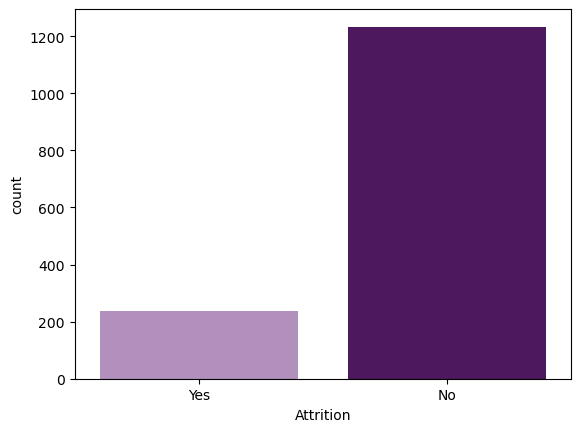

In [30]:
sns.countplot(x=df['Attrition'], hue=df['Attrition'], palette=['#B489C4', '#540C68'], legend=False)

In [32]:
numeric_col=list(df.select_dtypes(include=np.number).columns)
categorical_col=list(df.select_dtypes(include=object).columns)

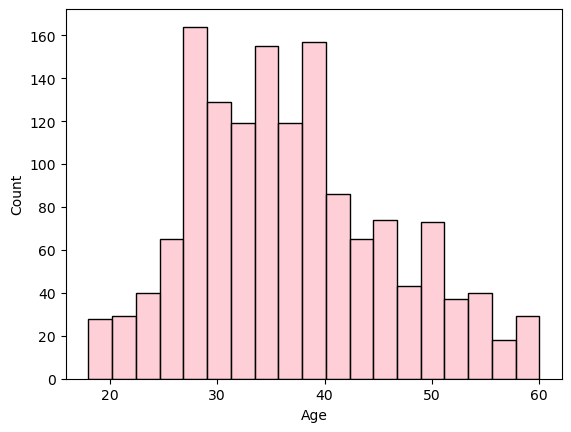

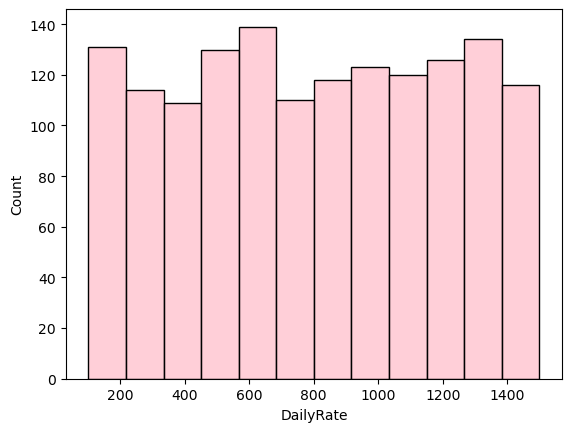

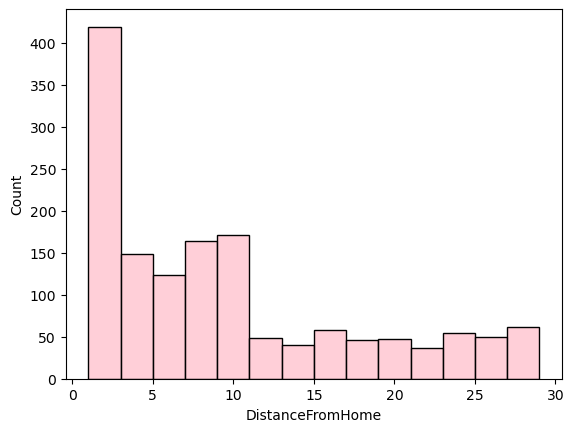

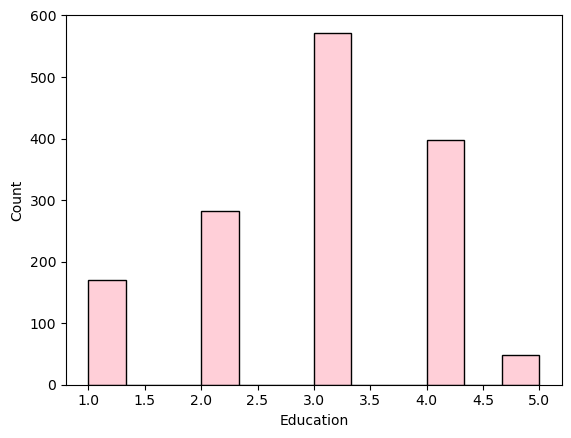

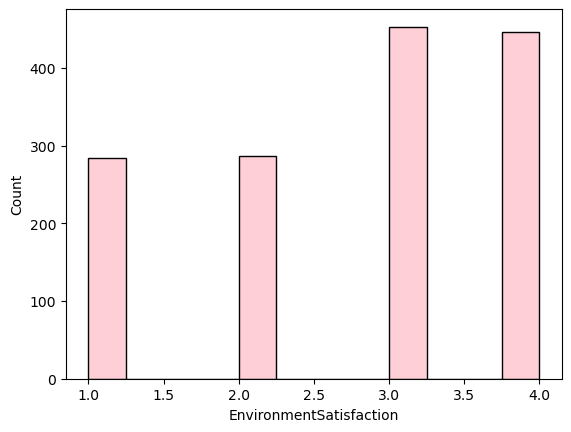

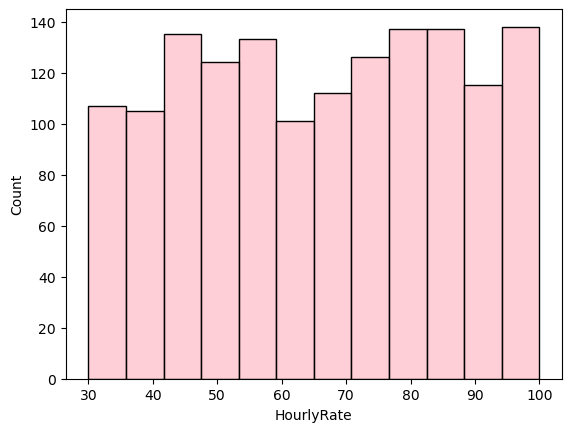

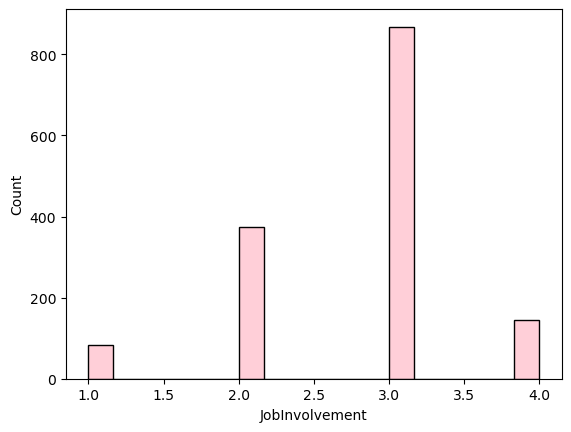

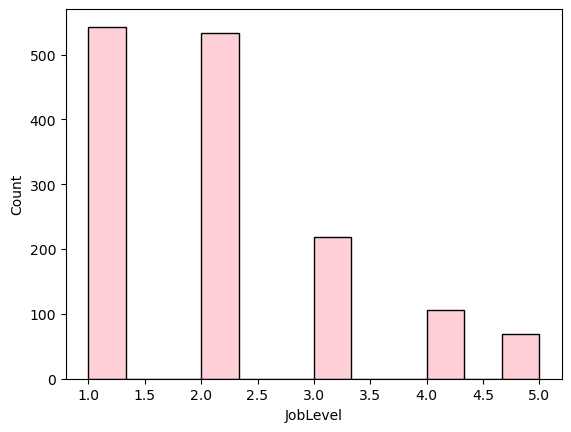

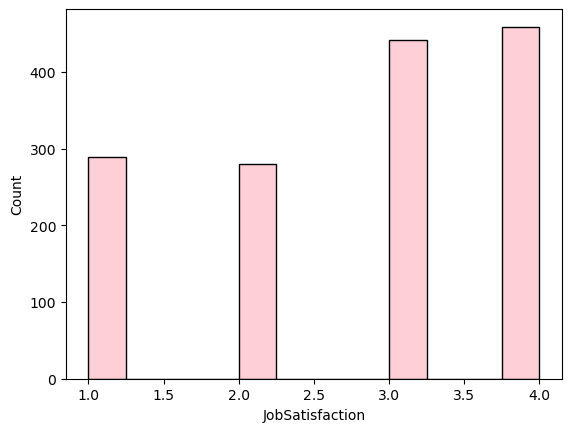

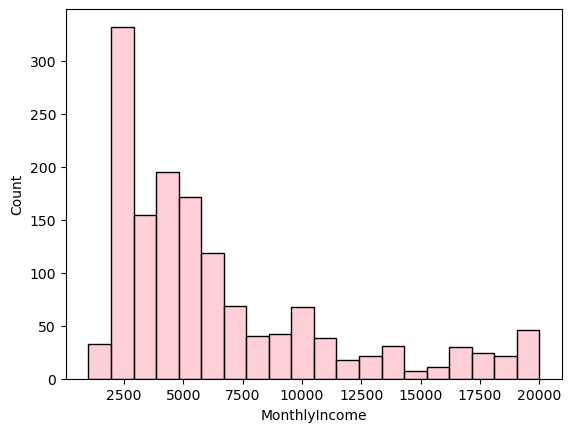

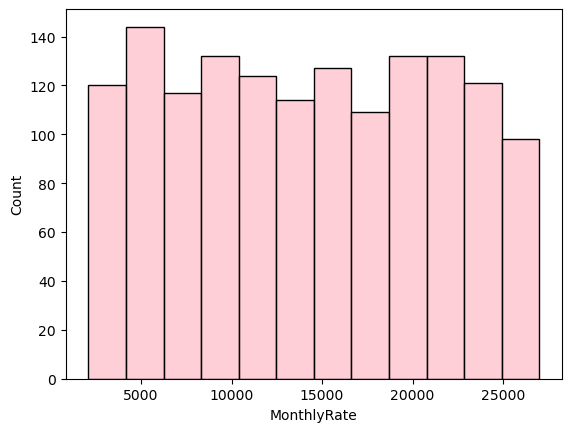

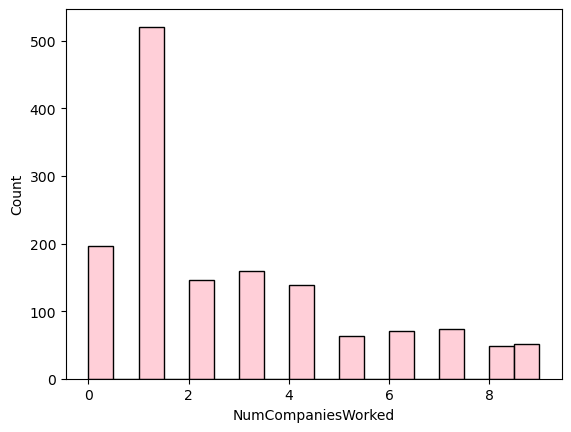

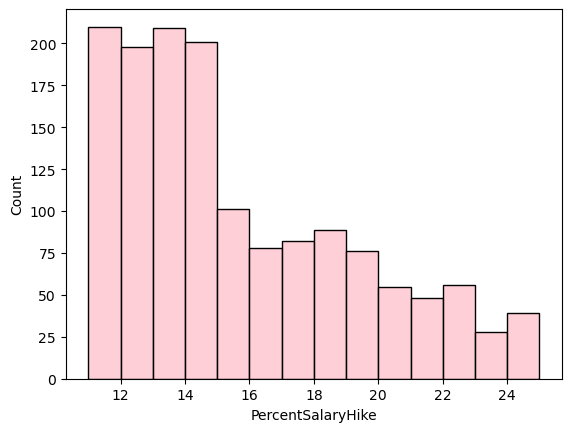

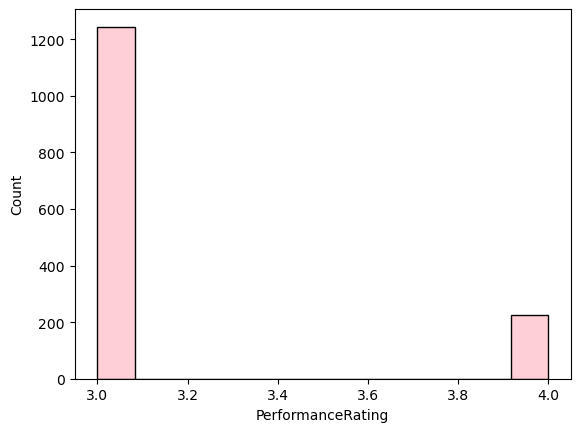

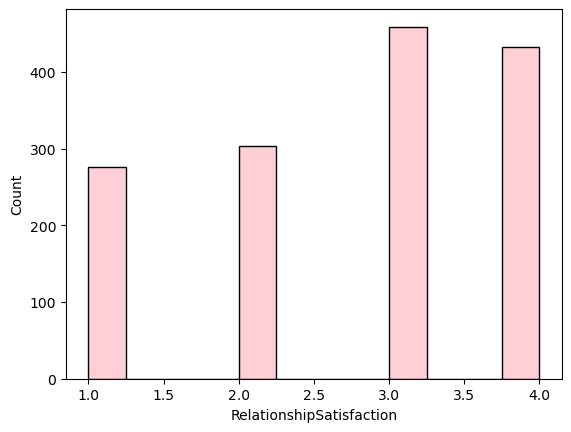

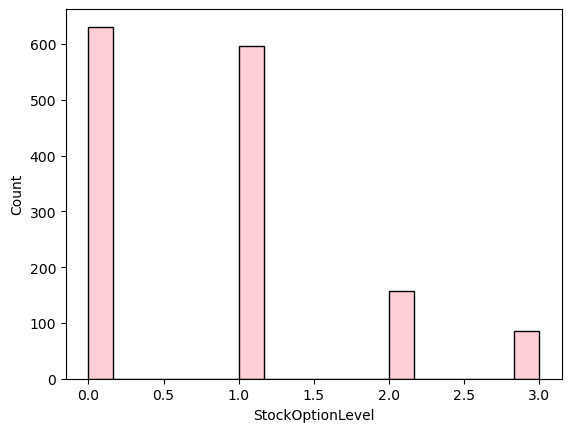

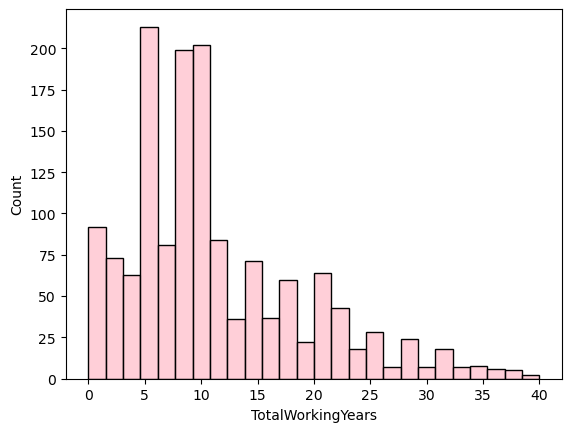

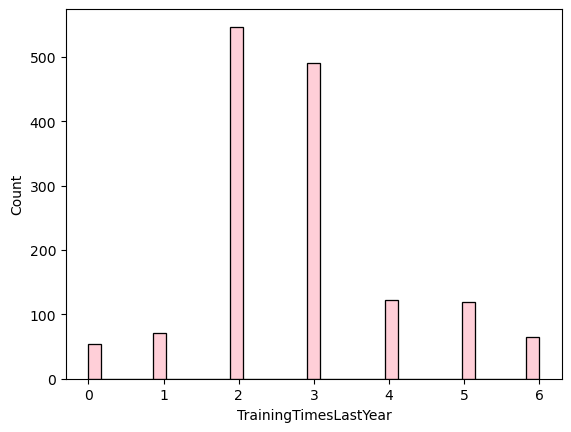

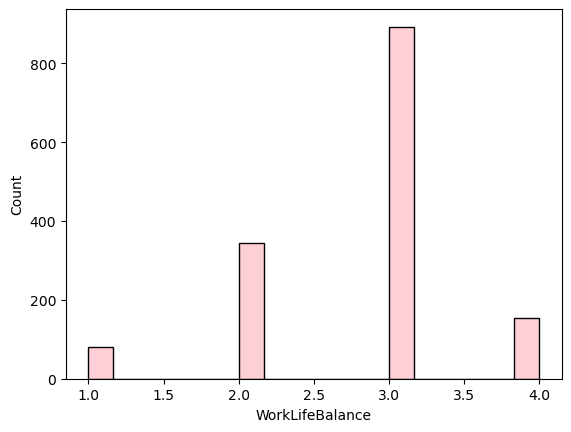

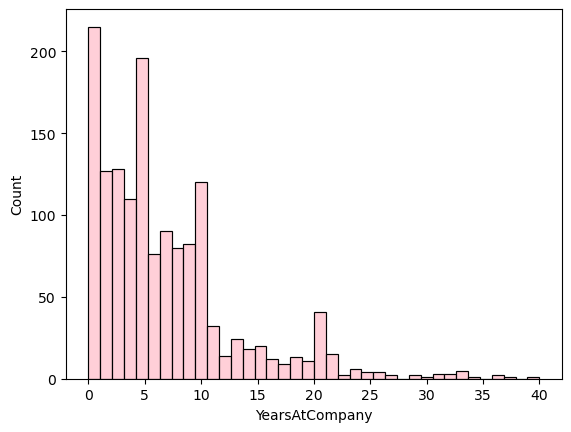

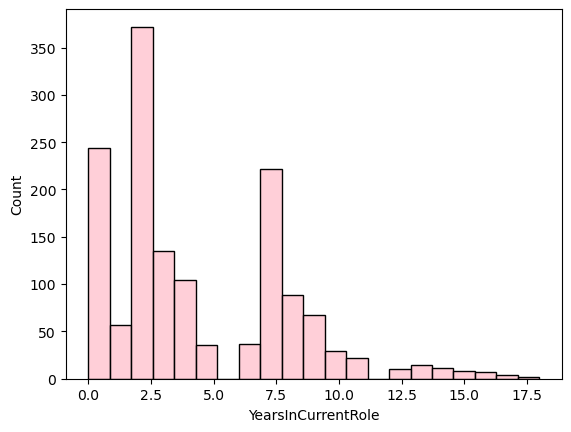

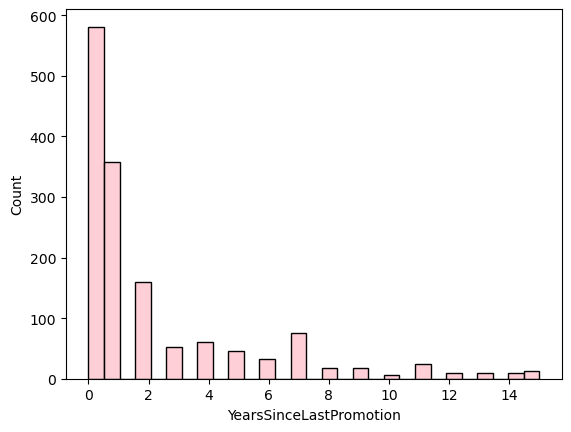

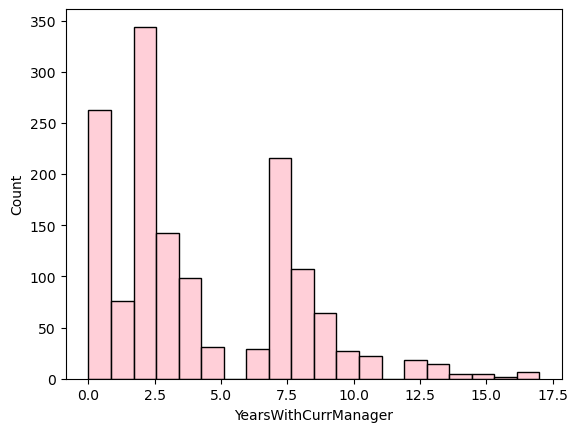

In [35]:
for col in numeric_col:
    sns.histplot(x=df[col], color="pink")
    plt.show()

In [46]:
df.groupby('JobRole')['MonthlyIncome'].mean()

JobRole
Healthcare Representative     7528.763359
Human Resources               4235.750000
Laboratory Technician         3237.169884
Manager                      17181.676471
Manufacturing Director        7295.137931
Research Director            16033.550000
Research Scientist            3239.972603
Sales Executive               6924.279141
Sales Representative          2626.000000
Name: MonthlyIncome, dtype: float64

<Axes: xlabel='Age', ylabel='MonthlyIncome'>

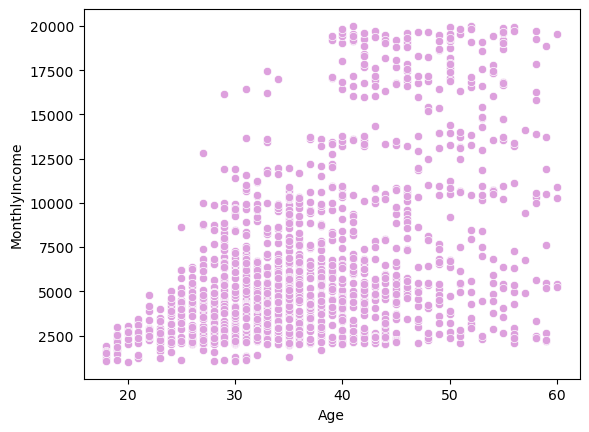

In [47]:
sns.scatterplot(data=df, x='Age',y='MonthlyIncome', color="plum")

# Conclusions:

# * Data Preprocessing

In [50]:
x=df.loc[:,df.columns!='Attrition']
y=df['Attrition']

In [51]:
x

,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,HourlyRate,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Travel_Rarely,1102,Sales,1,2,Life Sciences,2,Female,94,...,3,1,0,8,0,1,6,4,0,5
1,49,Travel_Frequently,279,Research & Development,8,1,Life Sciences,3,Male,61,...,4,4,1,10,3,3,10,7,1,7
2,37,Travel_Rarely,1373,Research & Development,2,2,Other,4,Male,92,...,3,2,0,7,3,3,0,0,0,0
3,33,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,4,Female,56,...,3,3,0,8,3,3,8,7,3,0
4,27,Travel_Rarely,591,Research & Development,2,1,Medical,1,Male,40,...,3,4,1,6,3,3,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,36,Travel_Frequently,884,Research & Development,23,2,Medical,3,Male,41,...,3,3,1,17,3,3,5,2,0,3
1466,39,Travel_Rarely,613,Research & Development,6,1,Medical,4,Male,42,...,3,1,1,9,5,3,7,7,1,7
1467,27,Travel_Rarely,155,Research & Development,4,3,Life Sciences,2,Male,87,...,4,2,1,6,0,3,6,2,0,3
1468,49,Travel_Frequently,1023,Sales,2,3,Medical,4,Male,63,...,3,4,0,17,3,2,9,6,0,8


In [52]:
y

0       Yes
1        No
2       Yes
3        No
4        No
       ... 
1465     No
1466     No
1467     No
1468     No
1469     No
Name: Attrition, Length: 1470, dtype: object

# * Machine Learning Model

In [66]:
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import LabelEncoder,MinMaxScaler,StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [56]:
label_encoder=LabelEncoder()
y=label_encoder.fit_transform(y)
y

array([1, 0, 1, ..., 0, 0, 0])

# * Label Encoding for Target Attrition

In [61]:
x=pd.get_dummies(x,drop_first=True)
x

,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,...,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Married,MaritalStatus_Single,OverTime_Yes
0,41,1102,1,2,2,94,3,2,4,5993,...,False,False,False,False,False,True,False,False,True,True
1,49,279,8,1,3,61,2,2,2,5130,...,False,False,False,False,True,False,False,True,False,False
2,37,1373,2,2,4,92,2,1,3,2090,...,True,False,False,False,False,False,False,False,True,True
3,33,1392,3,4,4,56,3,1,3,2909,...,False,False,False,False,True,False,False,True,False,True
4,27,591,2,1,1,40,3,1,2,3468,...,True,False,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,36,884,23,2,3,41,4,2,4,2571,...,True,False,False,False,False,False,False,True,False,False
1466,39,613,6,1,4,42,2,3,1,9991,...,False,False,False,False,False,False,False,True,False,False
1467,27,155,4,3,2,87,4,2,2,6142,...,False,False,True,False,False,False,False,True,False,True
1468,49,1023,2,3,4,63,2,2,2,5390,...,False,False,False,False,False,True,False,True,False,False


In [78]:
x_train,x_test,y_train,y_test=train_test_split(x,y,random_state=1,test_size=0.3, stratify=y)

In [79]:
scaler=StandardScaler()
x_train=pd.DataFrame(scaler.fit_transform(x_train),columns=x_train.columns)
x_test=pd.DataFrame(scaler.fit_transform(x_test),columns=x_train.columns)
x_test.head()

,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,...,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Married,MaritalStatus_Single,OverTime_Yes
0,-0.086712,0.328524,-0.908614,1.002199,0.247642,0.623866,0.403611,-0.926367,0.299877,-0.819419,...,2.209072,-0.265308,-0.324443,-0.265308,-0.502833,-0.552027,-0.274972,-0.919341,1.385832,-0.696311
1,-0.976016,0.760273,-0.135562,-0.858726,1.205628,-0.010625,0.403611,-0.926367,1.193428,-0.655361,...,-0.452679,-0.265308,-0.324443,-0.265308,1.988732,-0.552027,-0.274972,-0.919341,1.385832,-0.696311
2,-0.309038,-1.321285,-1.037457,-0.858726,-0.710343,0.819094,-1.067402,-0.926367,1.193428,-0.590651,...,-0.452679,-0.265308,-0.324443,-0.265308,1.988732,-0.552027,-0.274972,1.087735,-0.721588,1.436141
3,0.357940,0.232044,-0.393246,-0.858726,0.247642,-1.377220,0.403611,1.726411,1.193428,2.067247,...,-0.452679,3.769204,-0.324443,-0.265308,-0.502833,-0.552027,-0.274972,-0.919341,1.385832,1.436141
4,1.024918,-0.665220,-1.037457,-0.858726,-0.710343,1.258357,0.403611,0.842152,-1.487226,0.826135,...,-0.452679,-0.265308,-0.324443,-0.265308,-0.502833,1.811506,-0.274972,-0.919341,-0.721588,-0.696311


In [80]:
lr=LogisticRegression()
lr.fit(x_train,y_train)
y_pred=lr.predict(x_test)
y_pred

C:\Users\vivek\anaconda3\anaconda\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [81]:
metrics.confusion_matrix(y_test,y_pred)

array([[360,  10],
       [ 44,  27]], dtype=int64)

<Axes: >

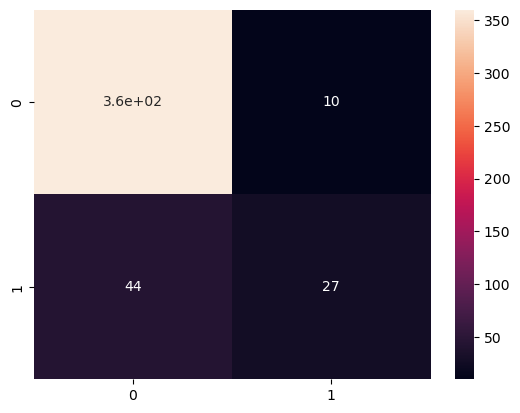

In [82]:
sns.heatmap(metrics.confusion_matrix(y_test,y_pred),annot=True)

In [83]:
metrics.accuracy_score(y_test,y_pred)

0.8775510204081632

In [84]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.89      0.97      0.93       370
           1       0.73      0.38      0.50        71

    accuracy                           0.88       441
   macro avg       0.81      0.68      0.72       441
weighted avg       0.87      0.88      0.86       441

